In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# T-test

### Welch's t-test

https://pymc-devs.github.io/pymc3/notebooks/BEST.html

In [2]:
drug = [101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101]
n_drug = len(drug)
placebo = [99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99]
n_placebo = len(placebo)
observed_diff = np.mean(drug) - np.mean(placebo)
print(observed_diff)

1.55775075988


In [3]:
n_sim = 10000
diffs = []
both = drug + placebo

for i in range(n_sim):
    np.random.shuffle(both)
    sim_drug = both[:n_drug]
    sim_placebo = both[n_drug:]
    
    diffs.append(np.mean(sim_drug) - np.mean(sim_placebo))

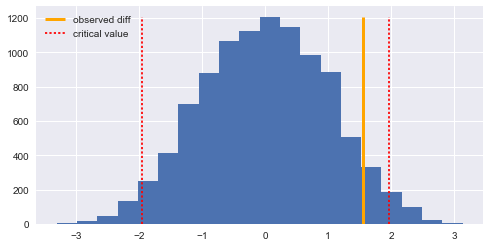

In [4]:
plt.figure(figsize=(8,4))
hist = plt.hist(diffs, bins=20);
hist_max = np.max(hist[0])
plt.vlines(observed_diff, 0, np.max(hist[0]), color='orange', 
           lw=3, label='observed diff')
plt.vlines([np.percentile(diffs, 2.5), np.percentile(diffs, 97.5)], 
           0, np.max(hist[0]), color='red', label='critical value', linestyle='dotted')
plt.legend(loc=2)

In [5]:
len([d for d in diffs if d >= observed_diff])/n_sim

0.0644

In [6]:
sim_drug = np.random.choice(both, size=5)
print(len(sim_drug))
print(len(both))

5
89


In [7]:
np.random.shuffle(both)

In [8]:
sim_drug = both[:n_drug]
sim_placebo = both[n_drug:]

In [9]:
len(sim_placebo)

42

# Correlation coefficient

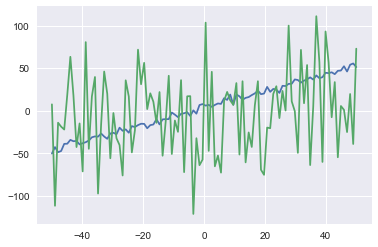

In [10]:
x = 1
b = 3
def f(x, a, b):
    return a*x + b
xs = np.linspace(-50, 50, 100)
ys = np.vectorize(f)(xs, x, b) + np.random.randn(100) * 3
ys_2 = ys/2 + np.random.randn(100) * 50
plt.plot(xs, ys)
plt.plot(xs, ys_2)

In [11]:
np.corrcoef((ys, ys_2))

array([[ 1.        ,  0.15199603],
       [ 0.15199603,  1.        ]])

In [12]:
from scipy.stats import pearsonr

In [13]:
pearsonr(ys, ys_2)

(0.15199602632088241, 0.13113618631220494)

Ok, maybe this is too easy

## Chi2 test

In [15]:
n = 100

obs_male = 62
obs_female = n - obs_male
expected = int(100 / 2)
n_dof = 2 - 1

In [16]:
chi2_ts = (obs_male - expected)**2 / expected + (obs_female - expected)**2 / expected

In [17]:
chi2_ts

5.76

In [18]:
from scipy.stats import chi2
chi2.sf(chi2_ts, n_dof)

0.016395071849192248

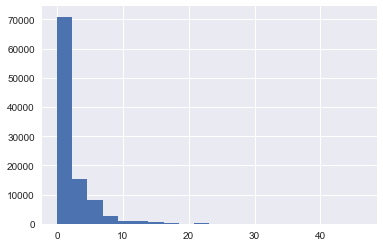

In [19]:
squared_diffs_sim = []
n_sim = 100000

for _ in range(n_sim):
    sim_male = np.random.poisson(lam=expected)
    sim_female = n - sim_male
#    print("{} male, {} female, sq diff: {}".format(sim_male, sim_female, (sim_male - expected)**2 + (sim_female - expected) ** 2))
    squared_diffs_sim.append((sim_male - expected)**2 / expected + (sim_female - expected)**2 / expected)
    
plt.hist(squared_diffs_sim, bins=20);

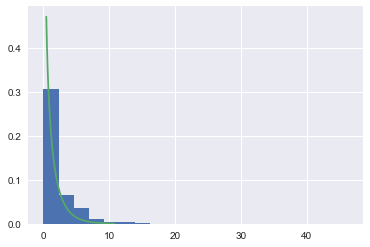

In [20]:
plt.hist(squared_diffs_sim, bins=20, normed=True);

n_dof = 1
xs = np.arange(chi2.ppf(0.5, n_dof), chi2.ppf(0.999, n_dof), .1)
ys = chi2.pdf(xs, n_dof)
plt.plot(xs, ys)

In [21]:
squared_diff_obs = (obs_male - expected)**2 / expected + (obs_female - expected) ** 2 / expected
len([d for d in squared_diffs_sim if d >= squared_diff_obs])/n_sim

0.10323

### ^^ Can't get this to work :(

# bootstrap confidence interval

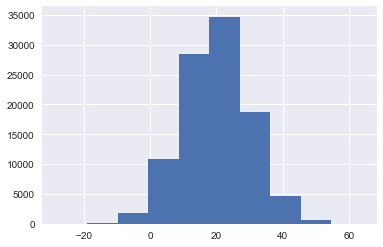

In [22]:
n = 100000
μ = 20
σ = 10
x = np.random.normal(loc=μ, scale=σ, size=n)
plt.hist(x);

In [23]:
n_sample = int(n/20)

In [24]:
n_sample

5000

In [25]:
x_sample = np.random.choice(x, n_sample)

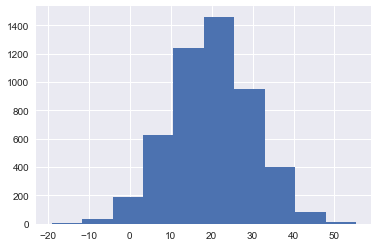

In [26]:
plt.hist(x_sample);

In [27]:
np.mean(x)

19.989001051194688

In [28]:
x_bar = np.mean(x_sample)
x_bar

20.029067723941239

### Manual CI

In [51]:
# Calculate the standard error of the sample mean:
stderr = np.std(x_sample) / np.sqrt(n_sample)
stderr

0.14008151023544935

In [31]:
from scipy.stats import norm

If you are somewhat familiar with statistics, you might remember the magic number 1.96 which corresponds to a 95% CI:

In [32]:
lower_bound = x_bar - 1.96 * stderr
upper_bound = x_bar + 1.96 * stderr
print("{:.1f} - {:.1f}".format(lower_bound, upper_bound))

19.8 - 20.3


But you can also use the Percent Point Function (inverse of the CDF) to calculate it automatically. The PPF function basically gives you the Z-score corresponding to the percentile. For a 95% CI, you need to allow for 2.5% on the left and the right side of the distribution.

In [33]:
norm.ppf(.975)

1.959963984540054

In [34]:
norm.ppf(.025)

-1.9599639845400545

In [35]:
(100 - 95) / 2

2.5

In [36]:
def print_ci(ci):
    """
    Calculate confidence interval and print it.
    :param ci: confidence interval width, between 0 and 100
    """
    percentile = (100 - ci) / 2
    percentile /= 100
    print("{}% confidence interval: {:.1f} - {:.1f}"
          .format(ci, x_bar + norm.ppf(percentile) * stderr,
                      x_bar + norm.ppf(1 - percentile) * stderr))
print_ci(60)
print_ci(75)
print_ci(90)
print_ci(95)

60% confidence interval: 19.9 - 20.1
75% confidence interval: 19.9 - 20.2
90% confidence interval: 19.8 - 20.3
95% confidence interval: 19.8 - 20.3


### Resample CI
Using Percentile Bootstrap

In [37]:
n_bootstrap_samples = 1000

resampled_means = [np.mean(bootstrap_sample) for bootstrap_sample in 
                   (np.random.choice(x_sample, size=n_sample, replace=True) for _ in range(n_bootstrap_samples))]

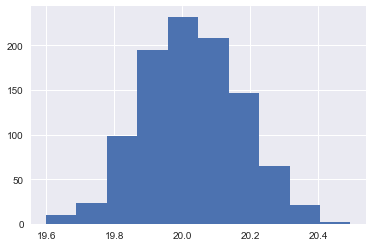

In [38]:
plt.hist(resampled_means);

In [52]:
np.std(resampled_means)

0.14345364061408869

In [55]:
# Note how this is pretty close to the sample mean that we calculated manually earlier! Here it is again:

In [56]:
np.std(x_sample) / np.sqrt(n_sample)

0.14008151023544935

In [39]:
def print_ci_bs(x, ci):
    """
    Calculate confidence interval and print it.
    :param x: data
    :param ci: confidence interval width, between 0 and 100
    """
    lb_perc = (100 - ci) / 2
    ub_perc = 100 - lb_perc
    print("{}% confidence interval: {:.1f} - {:.1f}"
          .format(ci, np.percentile(x, lb_perc),
                      np.percentile(x, ub_perc)))

print_ci_bs(resampled_means, 60)
print_ci_bs(resampled_means, 75)
print_ci_bs(resampled_means, 90)
print_ci_bs(resampled_means, 95)

60% confidence interval: 19.9 - 20.2
75% confidence interval: 19.9 - 20.2
90% confidence interval: 19.8 - 20.3
95% confidence interval: 19.8 - 20.3


## Cool!
What else can we use this for?

Imagine having a highly skewed distribution, and you're asked to summarize it as a single number. The mean isn't going to be a good approximatation as we can see. The median describes the distribution much better:

In [40]:
from scipy.stats import loglaplace

Median: 1.0185418731710216
Mean: 1.6886707865596295


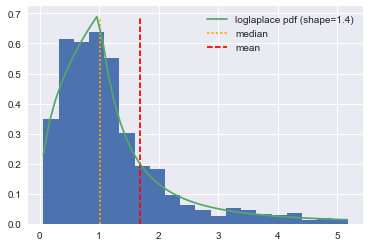

In [47]:
c = 1.4  # Shape parameter
lower_bound = loglaplace.ppf(0.01, c)
upper_bound = loglaplace.ppf(0.95, c)

n = 1000
values = loglaplace.rvs(c, size=n)
median = np.median(values)
mean = np.mean(values)
plt.hist(values, normed=True, bins=20, range=(lower_bound, upper_bound));

xs = np.arange(lower_bound, upper_bound, .1)
ys = loglaplace.pdf(xs, c)
plt.plot(xs, ys, label="loglaplace pdf (shape={})".format(c))

plt.vlines(median, 0, np.max(ys), label='median', linestyle='dotted', color='orange')
plt.vlines(mean, 0, np.max(ys), label='mean', linestyle='dashed', color='red')

plt.legend()

print("Median: {}".format(median))
print("Mean: {}".format(mean))

Ok, but you don't want to just give the median, you want to also include the uncertainty on the estimate.
Textbook statistics shows you how to do this for a mean as we saw above, but that doens't work for other estimates. Luckily the bootstrap method doesn't really care what you're estimating.

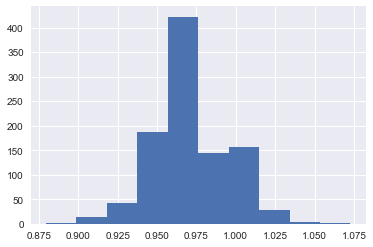

In [42]:
resamples_medians = [np.median(bootstrap_sample) for bootstrap_sample in 
                     (np.random.choice(values, size=n) for _ in range(n_bootstrap_samples))]
plt.hist(resamples_medians);

In [43]:
print_ci_bs(resamples_medians, 99)

99% confidence interval: 0.9 - 1.0


As we can see, this estimate is very robust.